In [ ]:
# Tested on Python3.8.10
# !pip install tensorflow==2.12.0
# !pip install seaborn==0.12.2
# !pip install matplotlib==3.7.1
# !pip install numpy==1.23.5
# !pip install pandas==2.0.1
# !pip install cesium==0.12.1
# !pip install prophet==1.1.3
# !pip install scikit_learn==1.2.2
# !pip install openpyxl==3.1.2

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import cesium as cs

In [2]:
np.__version__

'1.23.5'

---

In [3]:
# Importing the data
raw_csv_data = pd.read_excel("../Input/CallCenterData.xlsx")

In [4]:
# check point of data
df_comp = raw_csv_data.copy()

In [5]:
df_comp.head()

,month,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
0,2010-01-31,631,8,6,2,19,1,4
1,2010-02-28,633,9,7,3,27,1,3
2,2010-03-31,766,4,4,2,24,1,1
3,2010-04-30,768,12,6,3,32,1,1
4,2010-05-31,1003,2,7,2,42,1,4


In [6]:
df_comp.describe()

,month,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
count,132,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,2015-07-16 06:10:54.545454592,9856.704545,2411.856061,514.204545,112.454545,651.681818,2.250000,2.537879
min,2010-01-31 00:00:00,631.000000,2.000000,4.000000,2.000000,19.000000,0.000000,1.000000
25%,2012-10-23 06:00:00,3744.250000,608.750000,119.000000,39.750000,363.500000,1.000000,1.000000
50%,2015-07-15 12:00:00,9651.500000,2613.500000,486.000000,130.500000,581.000000,2.000000,3.000000
75%,2018-04-07 12:00:00,15590.750000,4000.500000,901.500000,171.250000,997.750000,3.000000,4.000000
max,2020-12-31 00:00:00,23602.000000,5138.000000,1310.000000,229.000000,1535.000000,11.000000,4.000000
std,NaN,6221.071304,1714.759241,392.882978,69.680773,395.949633,1.867255,1.161766


In [7]:
# check for the null values
df_comp.isna().sum()

month            0
Healthcare       0
Telecom          0
Banking          0
Technology       0
Insurance        0
#ofphonelines    0
#noofchannels    0
dtype: int64

---

## Time Series Visualization

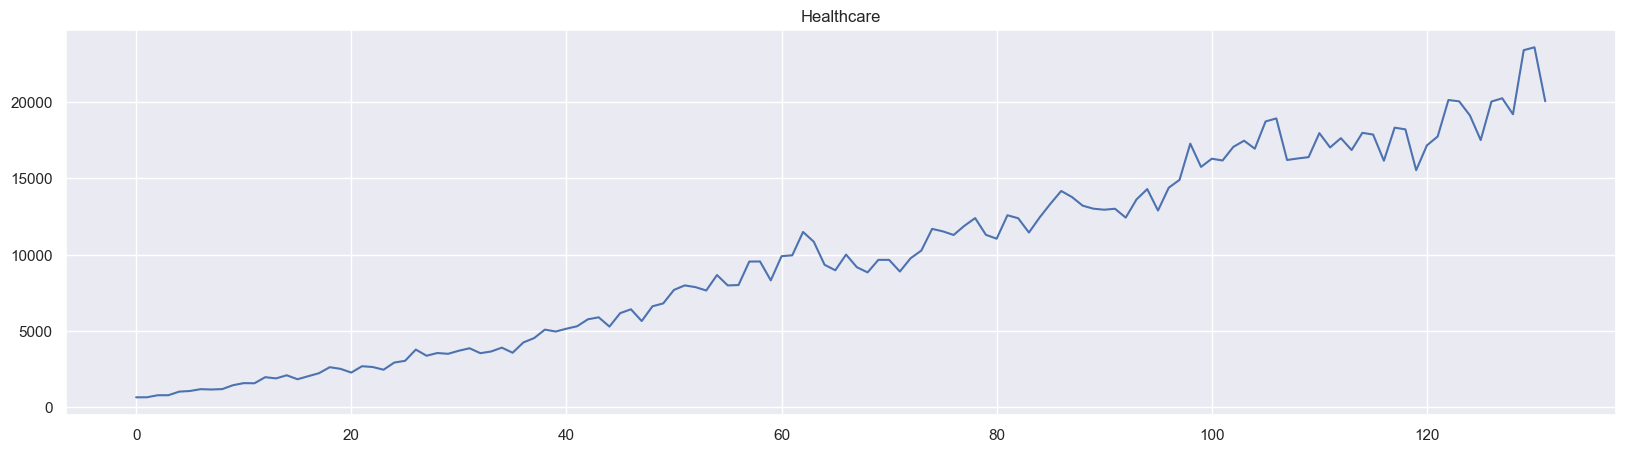

In [8]:
df_comp.Healthcare.plot(figsize=(20,5), title="Healthcare")
plt.show()

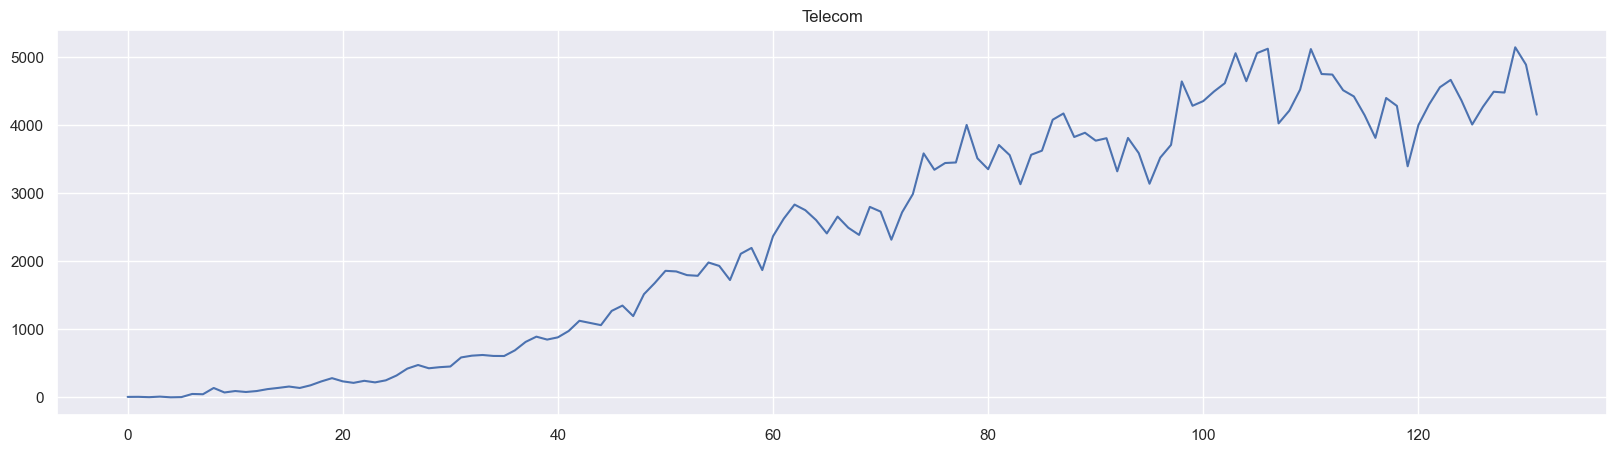

In [9]:
df_comp.Telecom.plot(figsize=(20,5), title="Telecom")
plt.show()

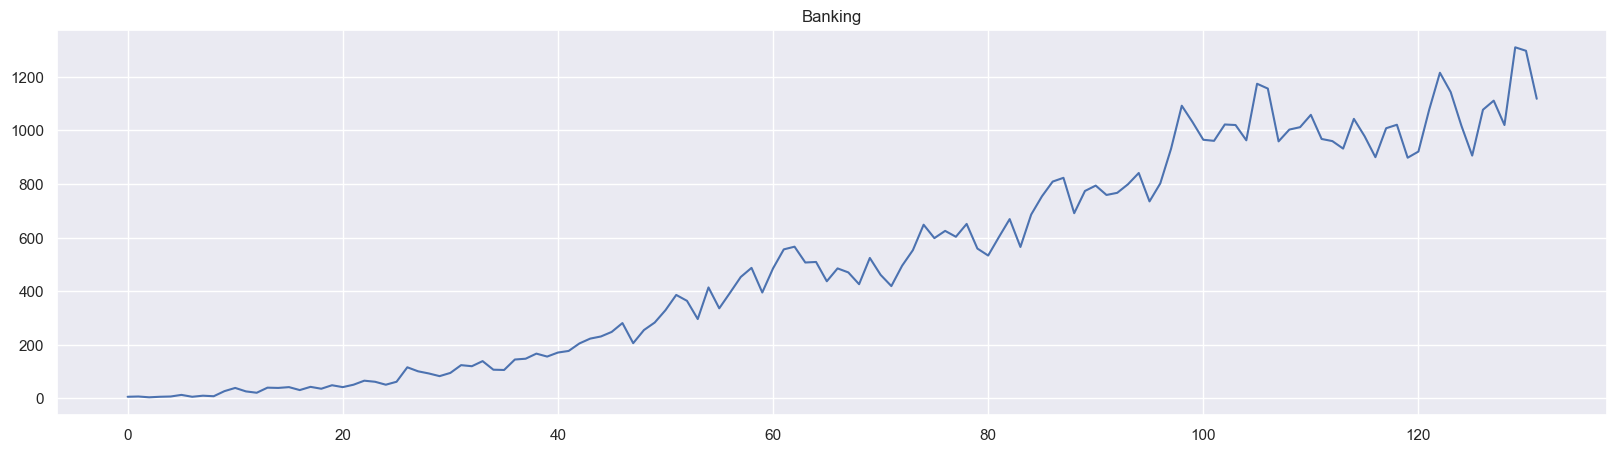

In [10]:
df_comp.Banking.plot(figsize=(20,5), title="Banking")
plt.show()

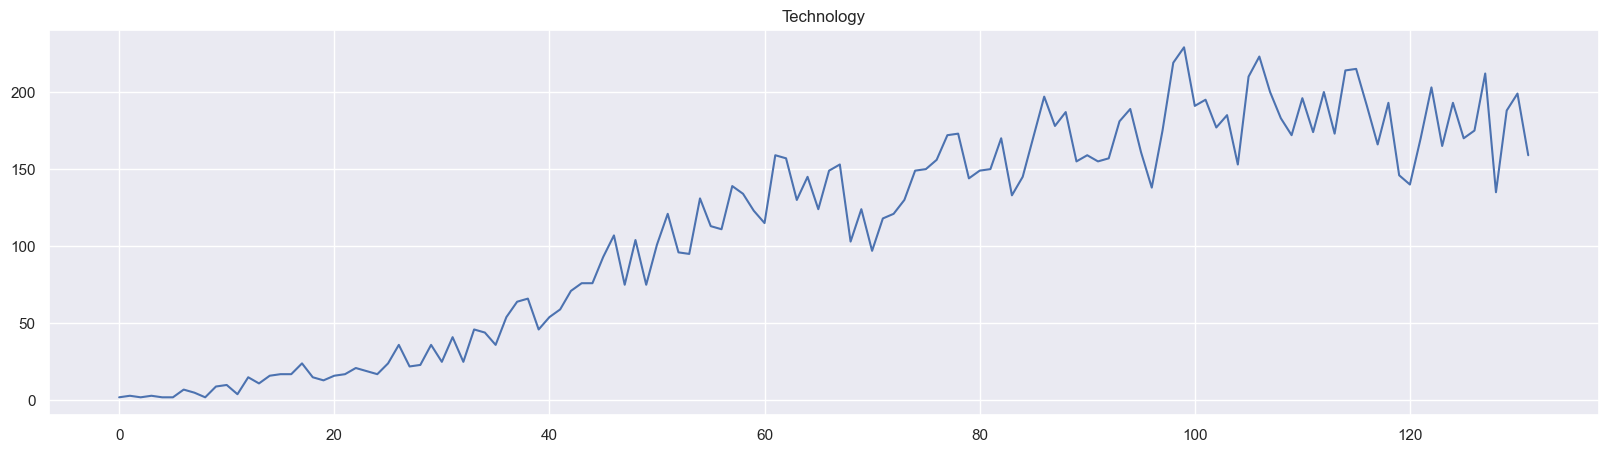

In [11]:
df_comp.Technology.plot(figsize=(20,5), title="Technology")
plt.show()

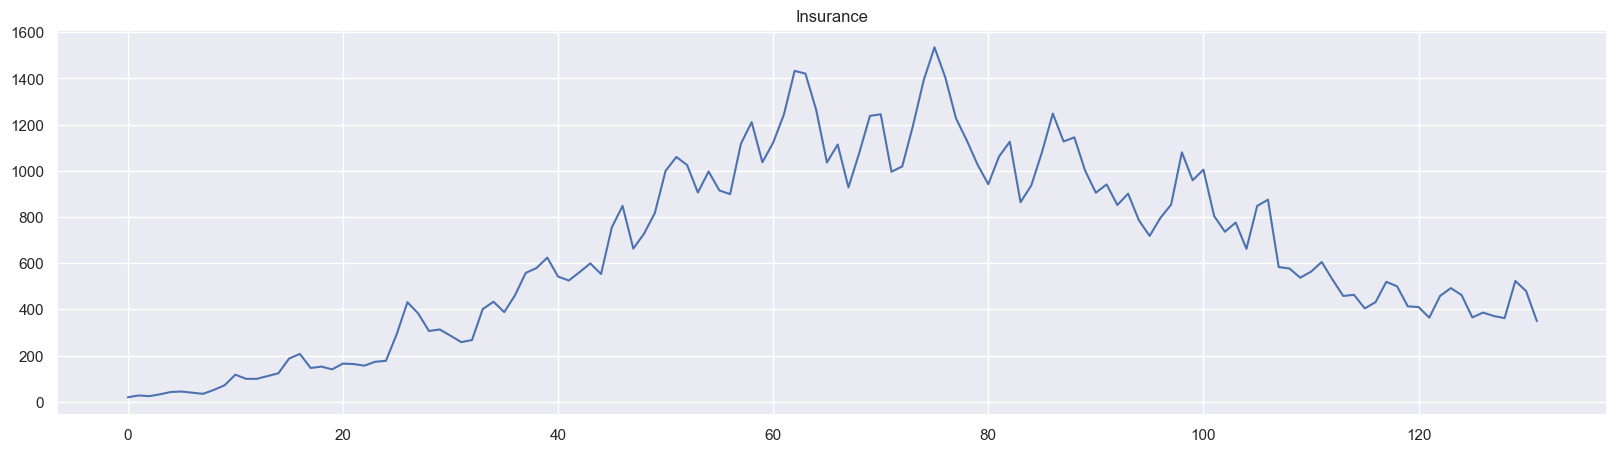

In [12]:
df_comp.Insurance.plot(figsize=(20,5), title="Insurance")
plt.show()

In [13]:
df = df_comp[["month", "Healthcare"]]

In [ ]:
# Convert a datetime column to Unix timestamps and store as integers

df['ts'] = df['month'].apply(lambda x: x.timestamp()).astype(int)


In [15]:
df.head()

,month,Healthcare,ts
0,2010-01-31,631,1264896000
1,2010-02-28,633,1267315200
2,2010-03-31,766,1269993600
3,2010-04-30,768,1272585600
4,2010-05-31,1003,1275264000


---

## Reshaping the data

In [16]:
# Reshaping the data to the following format:
# Using the previous 5 time periods as predictors
# Predicting the 6th time period

n_past = 5  # Number of past time periods to use as predictors
target_data = []

for i in range(len(df)):
    past_values = []
    time_periods = []

    for j in range(n_past + 1):
        try:
            past_values.append(df.Healthcare[i + j])
            time_periods.append(df.ts[i + j])
        except Exception as e:
            continue

    if len(past_values) > n_past:
        try:
            # Create a data point with an array of past values, their corresponding time periods, and the target value
            target_data.append([np.array(past_values), np.array(time_periods), df.Healthcare[i + n_past]])
        except Exception as e:
            continue


In [17]:
# Shaping the data into the required format using a DataFrame
cesium_df = pd.DataFrame(target_data).rename(columns={0: 'y', 1: 'ts', 2: 'target'})


In [18]:
cesium_df.head()

,y,ts,target
0,"[631, 633, 766, 768, 1003]","[1264896000, 1267315200, 1269993600, 127258560...",1046
1,"[633, 766, 768, 1003, 1046]","[1267315200, 1269993600, 1272585600, 127526400...",1165
2,"[766, 768, 1003, 1046, 1165]","[1269993600, 1272585600, 1275264000, 127785600...",1143
3,"[768, 1003, 1046, 1165, 1143]","[1272585600, 1275264000, 1277856000, 128053440...",1169
4,"[1003, 1046, 1165, 1143, 1169]","[1275264000, 1277856000, 1280534400, 128321280...",1424


In [19]:
# Converting selected columns from cesium_df into a dictionary format
cs_df = cesium_df[['ts', 'y']].to_dict('list')


In [20]:
cs_df

{'ts': [array([1264896000, 1267315200, 1269993600, 1272585600, 1275264000]),
  array([1267315200, 1269993600, 1272585600, 1275264000, 1277856000]),
  array([1269993600, 1272585600, 1275264000, 1277856000, 1280534400]),
  array([1272585600, 1275264000, 1277856000, 1280534400, 1283212800]),
  array([1275264000, 1277856000, 1280534400, 1283212800, 1285804800]),
  array([1277856000, 1280534400, 1283212800, 1285804800, 1288483200]),
  array([1280534400, 1283212800, 1285804800, 1288483200, 1291075200]),
  array([1283212800, 1285804800, 1288483200, 1291075200, 1293753600]),
  array([1285804800, 1288483200, 1291075200, 1293753600, 1296432000]),
  array([1288483200, 1291075200, 1293753600, 1296432000, 1298851200]),
  array([1291075200, 1293753600, 1296432000, 1298851200, 1301529600]),
  array([1293753600, 1296432000, 1298851200, 1301529600, 1304121600]),
  array([1296432000, 1298851200, 1301529600, 1304121600, 1306800000]),
  array([1298851200, 1301529600, 1304121600, 1306800000, 1309392000]),


---

In [21]:
from cesium import featurize

In [22]:
# Function to calculate the mean of the signal
def mean_signal(t, m, e):
    return np.mean(m)

# Function to calculate the standard deviation of the signal
def std_signal(t, m, e):
    return np.std(m)

# Function to calculate the mean square of the signal
def mean_square_signal(t, m, e):
    return np.mean(m ** 2)

# Function to calculate the absolute differences of the signal
def abs_diffs_signal(t, m, e):
    return np.sum(np.abs(np.diff(m)))


In [23]:
# Define a dictionary that associates feature names with their respective functions
feature_functions = {
    "mean": mean_signal,          # Calculate mean of the signal
    "std": std_signal,            # Calculate standard deviation of the signal
    "mean2": mean_square_signal,  # Calculate the mean of the squared signal values
    "abs_diffs": abs_diffs_signal  # Calculate the sum of absolute differences between consecutive signal values

}

In [24]:
# Extracting Features from Time Series Data

# Featurize the time series data using the specified functions and features
feature_set_cesium = featurize.featurize_time_series(
    times=cs_df["ts"],             # Time values of the time series
    values=cs_df["y"],             # Signal values of the time series
    errors=None,                   # Additional error information (if available)
    features_to_use=list(feature_functions.keys()),  # List of features to compute
    custom_functions=feature_functions  # Custom feature functions defined in the dictionary
)


In [25]:
# Adding a "target" column to the feature set and populating it with values from the "target" column in cesium_df
fset_cesium["target"] = cesium_df["target"]


In [26]:
fset_cesium.head()

feature,mean,std,mean2,abs_diffs,target
channel,0,0,0,0,
0,760.2,135.586725,596287.8,372.0,1046
1,843.2,156.500990,735478.8,413.0,1165
2,949.6,158.258775,926786.0,399.0,1143
3,1025.0,141.773058,1070724.6,419.0,1169
4,1105.2,67.859856,1226072.0,210.0,1424


In [ ]:
# Extracting input features (X) and target values (Y) from the feature set
X = fset_cesium.drop("target", axis=1).values 
Y = fset_cesium["target"] 


In [28]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

---

## Training the ML Algorithm

In [29]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras import optimizers

In [30]:
X_train.shape

(101, 4)

In [31]:
# Define training parameters

epochs = 1000  # Number of training epochs
lr = 0.05      # Learning rate for optimization

# Define an optimizer
adam = optimizers.Adam(lr)  # Using the Adam optimizer with the specified learning rate


In [32]:
# Create a sequential neural network model

model_mlp = Sequential()

# Add a hidden layer with 100 neurons and ReLU activation function
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))

# Add an output layer with 1 neuron (for regression) without activation function
model_mlp.add(Dense(1))

# Compile the model, specifying the loss function and optimizer
model_mlp.compile(loss='mse', optimizer=adam)  # Mean Squared Error (MSE) loss and the specified optimizer

# Display a summary of the model architecture
model_mlp.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Fit the neural network model with training data

mlp_history = model_mlp.fit(X_train, Y_train, 
                            epochs=epochs, verbose=2)


Epoch 1/1000
4/4 - 0s - loss: 4838267774042112.0000 - 499ms/epoch - 125ms/step
Epoch 2/1000
4/4 - 0s - loss: 3258487802953728.0000 - 6ms/epoch - 2ms/step
Epoch 3/1000
4/4 - 0s - loss: 261075056459776.0000 - 5ms/epoch - 1ms/step
Epoch 4/1000
4/4 - 0s - loss: 710819436298240.0000 - 6ms/epoch - 2ms/step
Epoch 5/1000
4/4 - 0s - loss: 168773894012928.0000 - 6ms/epoch - 2ms/step
Epoch 6/1000
4/4 - 0s - loss: 4224809959424.0000 - 7ms/epoch - 2ms/step
Epoch 7/1000
4/4 - 0s - loss: 26164437450752.0000 - 5ms/epoch - 1ms/step
Epoch 8/1000
4/4 - 0s - loss: 37905468751872.0000 - 11ms/epoch - 3ms/step
Epoch 9/1000
4/4 - 0s - loss: 28325200265216.0000 - 8ms/epoch - 2ms/step
Epoch 10/1000
4/4 - 0s - loss: 14709272084480.0000 - 6ms/epoch - 1ms/step
Epoch 11/1000
4/4 - 0s - loss: 6095064006656.0000 - 8ms/epoch - 2ms/step
Epoch 12/1000
4/4 - 0s - loss: 1570381496320.0000 - 7ms/epoch - 2ms/step
Epoch 13/1000
4/4 - 0s - loss: 153623298048.0000 - 8ms/epoch - 2ms/step
Epoch 14/1000
4/4 - 0s - loss: 501471559

In [34]:
# Make predictions on test data
mlp_pred = model_mlp.predict(X_test)

1/1 [==============================] - 0s 63ms/step


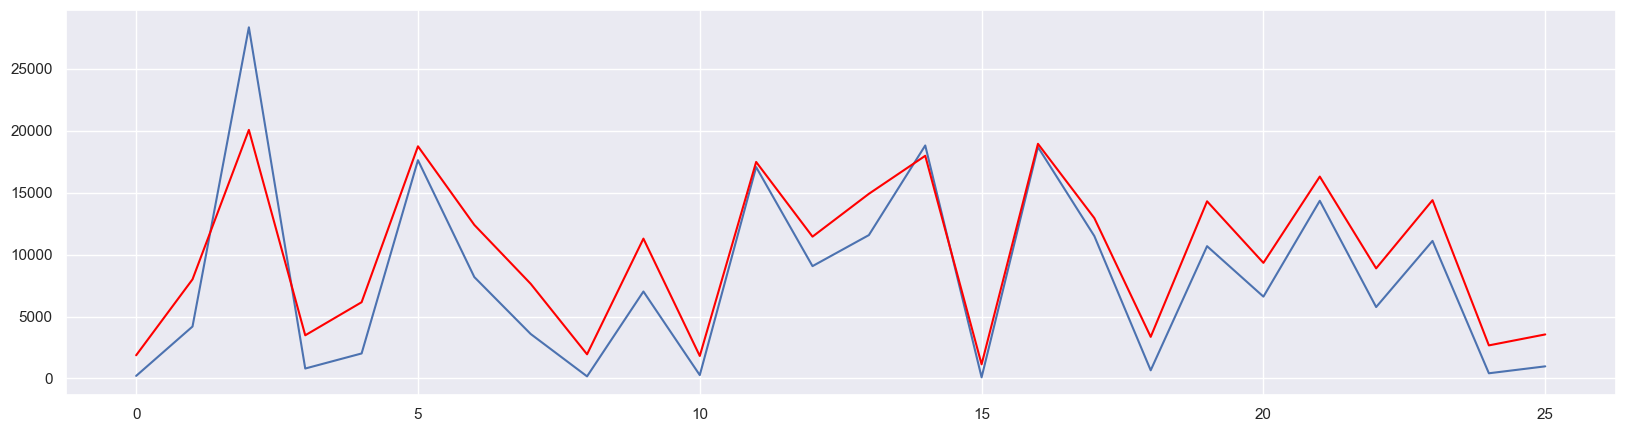

In [35]:
# Plot the results

plt.figure(figsize=(20, 5))

# Plot the predictions in blue
plt.plot(mlp_pred, label='Predictions')

# Plot the actual target values in red
plt.plot(Y_test.values, color='red', label='Actual')

# Show the plot
plt.legend()
plt.show()


In [36]:
# Save the trained neural network model to a file

model_mlp.save("../Output/models/model_cesium.h5")


---